In [1]:
# read xlsx file
import sys
sys.path.append('../')

import pandas as pd
from pathlib import Path
from rich.console import Console

console = Console()

# cfgs
proj_dir = Path('../Metric')
dataset_name = 'MED_HARVARD_SPECT_MRI'
method_names = "Metric_panrwkv_v8_cond_norm.xlsx" #['Metric_panrwkv_v3']

console.print(f'project dir: {proj_dir}')
assert proj_dir.exists(), f'{proj_dir.absolute()} is not exists()'
console.print('configs:')
console.print(f'{dataset_name=}')


dataset_name = dataset_name.upper()
if isinstance(method_names, str) and method_names != 'all':
    method_names = [method_names]
if method_names == 'all':
    paths = list(proj_dir.rglob(f'{dataset_name}/*.xlsx'))
    method_names = [p.name for p in paths]
else:
    paths = [proj_dir / f'{dataset_name}/{metric_name}' for metric_name in method_names]
console.print(f'{method_names=}')


def read_one_excel_file(path):
    excel_file = pd.ExcelFile(path)
    metric_names = excel_file.sheet_names
    dfs = pd.read_excel(path, sheet_name=metric_names)

    concat_df = pd.concat(dfs, axis=1)
    concat_df = concat_df.drop(index=[0], axis=1)
    columns = concat_df.columns.droplevel(1)
    concat_df.columns = columns

    # calculate the each metric's mean and std
    mean_df = concat_df.mean(axis=0)
    mean_df = mean_df.to_frame().T
    mean_df.index = ['mean']

    std_df = concat_df.std(axis=0)
    std_df = std_df.to_frame().T
    std_df.index = ['std']

    # concat the mean and std to dataframe
    concat_df = pd.concat([concat_df, mean_df, std_df])
    
    return concat_df

def pd_file_get_mean_and_std(pd: pd.DataFrame):
    mean = pd.loc['mean']
    std = pd.loc['std']
    return mean, std

tabs = []
for p in paths:
    assert p.exists(), f'{p} is not exists()'
    concat_df = read_one_excel_file(p)
    tabs.append(concat_df)
    
console.print('read excel files done!')

## attributions
metric_names = tabs[0].columns.tolist()


console.print('metrics: {}'.format(metric_names))



project dir: ../Metric

configs:

dataset_name='MED_HARVARD_SPECT_MRI'

method_names=['Metric_panrwkv_v8_cond_norm.xlsx']

read excel files done!

metrics: ['SD', 'PSNR', 'MSE', 'MI', 'VIF', 'AG', 'CC', 'SCD', 'EN', 'Qabf', 'SF', 'SSIM']

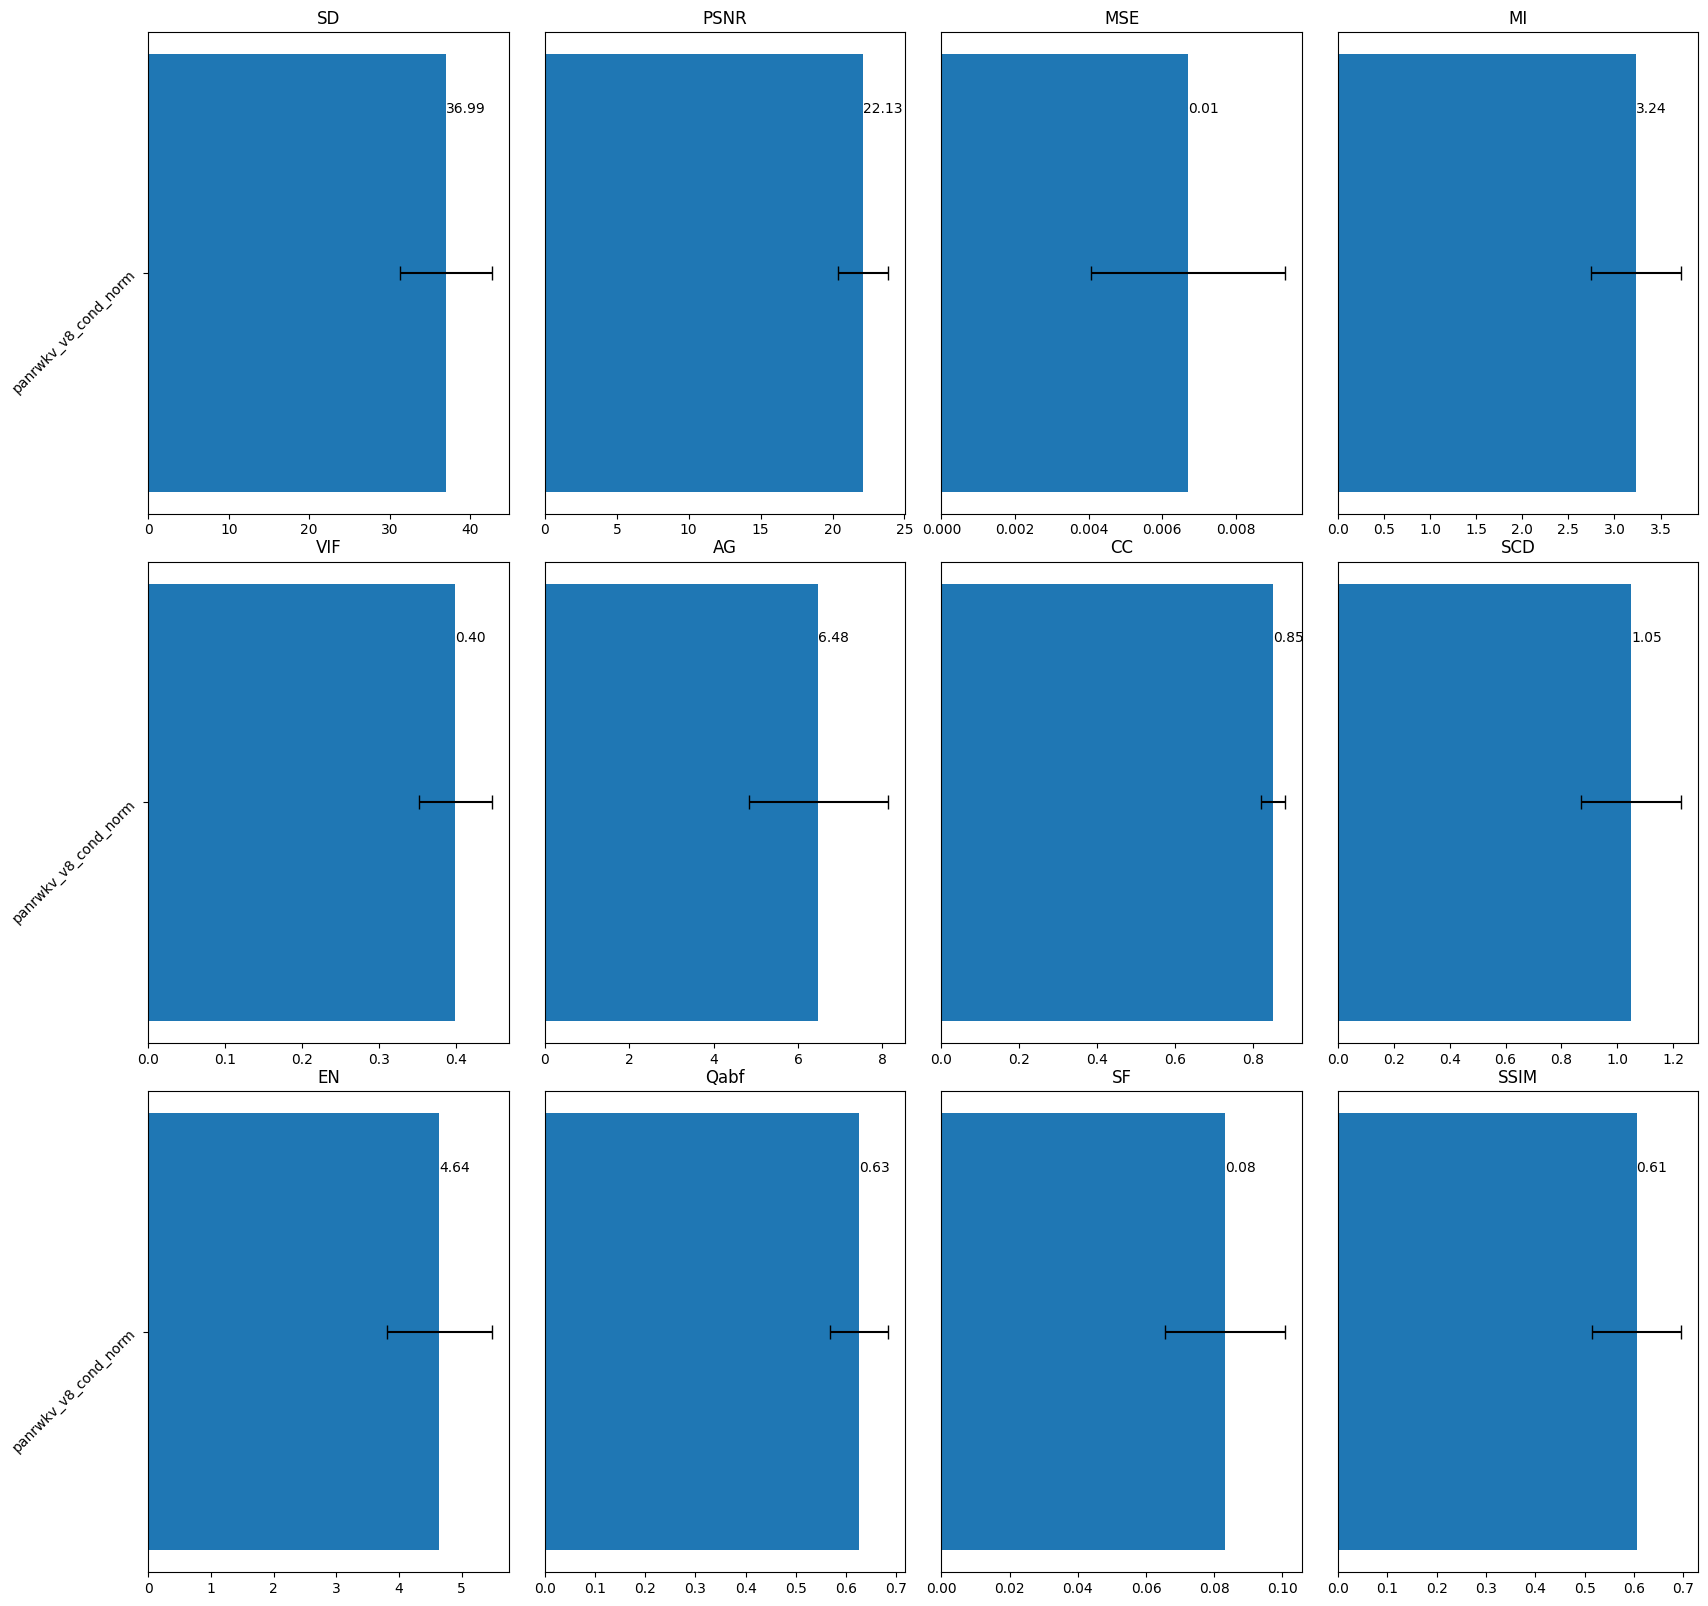

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# plot bar plots of every metrics of each method
# group by metrics and transpose the plot
# y-axis is methods name
# x-axis is metrics values (mean and std)

# merge to one figure
x_axis_n_axes = np.sqrt(len(metric_names)).astype(int)
y_axis_n_axes = np.ceil(len(metric_names) / x_axis_n_axes).astype(int)
pattern = re.compile(r'(?<=Metric_)[\d\w-]+(?=.xlsx)')

fig = plt.figure(figsize=(20, 20))
spec = GridSpec(x_axis_n_axes, y_axis_n_axes, figure=fig, wspace=0.1, hspace=0.1)

for i, metric_name in enumerate(metric_names):
    # get ax
    ax = fig.add_subplot(spec[i // y_axis_n_axes, i % y_axis_n_axes])
    
    if i % y_axis_n_axes != 0:
        ax.get_yaxis().set_visible(False)
    
    means = []
    for ii, tab in enumerate(tabs):
        mean, std = pd_file_get_mean_and_std(tab.loc[:, metric_name])
        # bar plot
        ax.barh(ii, mean, xerr=std, label=method_names[ii], capsize=5)
        means.append(mean)
        ax.text(mean, ii+0.3, f'{mean:.2f}', va='center', ha='right' if mean < 0 else 'left')
        
    # plot the highest value among all methods (a dot line)
    # along the y-axis
    
    # means = np.sort(means, axis=0)
    # ax.axvline(means[-1], color='r', linestyle='--', lw=1)
    # # and the second max
    # ax.axvline(means[-2], color='g', linestyle='--', lw=1)
    
    # ax.set_ylabel('methods')
    # methods name
    ax.set_yticks(range(len(method_names)))
    # only methods' name
    # split 'Metric_' prefix
    ax.set_yticklabels([pattern.findall(name)[0] for name in method_names], rotation=45)
    ax.set_title(f'{metric_name}')
    
    # 调整轴的范围
    if len(means) > 1:
        ax.set_xlim(np.min(means) - 0.05 * np.ptp(means), np.max(means) + 0.05 * np.ptp(means))
        
    # ax.legend()
plt.show()
plt.close()

In [3]:
# rank each method by each metric
# sort by the mean value of each metric

# get the mean value of each metric
means = []
index_name = []
for method, tab in zip(method_names, tabs):
    mean, std = pd_file_get_mean_and_std(tab)
    means.append(mean)
    index_name.append(pattern.findall(method)[0])

mean_tab = pd.DataFrame(means)
mean_tab.index = index_name

# mean_tab.to_excel(proj_dir / f'{dataset_name}_mean.xlsx', float_format='%.4f')

In [4]:
mean_tab

,SD,PSNR,MSE,MI,VIF,AG,CC,SCD,EN,Qabf,SF,SSIM
panrwkv_v8_cond_norm,36.988042,22.130045,0.0067,3.236665,0.399057,6.483603,0.850986,1.049298,4.642295,0.625794,0.083059,0.605223


In [23]:
import re



pattern.findall('Metric_MATR.xlsx')

['MATR']